# Factor-Based Backtesting System

This notebook demonstrates a modular backtesting framework for crypto assets (BTC, ETH).
It imports logic from the `src/` directory to keep the research clean and reproducible.

In [8]:
import sys
import os

# Add src to path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

import pandas as pd
import matplotlib.pyplot as plt
from data_loader import download_data
from factors import momentum_signal, mean_reversion_signal, ma_crossover_signal
from backtester import run_backtest
from metrics import calculate_metrics
from plotting import plot_equity_curves, plot_drawdowns

%matplotlib inline

## 1. Data Loading
We fetch historical daily data from Yahoo Finance.

In [9]:
tickers = ['BTC-USD', 'ETH-USD']
start_date = '2020-01-01'
end_date = '2023-12-31'

prices = download_data(tickers, start_date, end_date)
prices.head()

/Users/bipinrai/git/Quant-trading-research-project/quant-factor-backtest/src/data_loader.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  2 of 2 completed

Data download complete.


Ticker,BTC-USD,ETH-USD
Date,,
2020-01-01,7200.174316,130.802002
2020-01-02,6985.470215,127.410179
2020-01-03,7344.884277,134.171707
2020-01-04,7410.656738,135.069366
2020-01-05,7411.317383,136.276779


## 2. Strategy Definition
We generate signals for three distinct strategies:
1. **Momentum**: Trend following (Lookback = 20 days)
2. **Mean Reversion**: Z-Score based (Window = 20, Threshold = 1.5)
3. **MA Crossover**: Golden/Death Cross (Short=20, Long=60)

In [10]:
strategies = {
    'Momentum': momentum_signal(prices),
    'Mean Reversion': mean_reversion_signal(prices),
    'MA Crossover': ma_crossover_signal(prices)
}

## 3. Backtesting
We run the vectorized backtest engine for each strategy.

In [11]:
results = {}
equity_curves = pd.DataFrame()

for name, signals in strategies.items():
    res = run_backtest(prices, signals)
    results[name] = res['returns']
    
    # Store equity curves for plotting (taking average of assets for simplicity in plot)
    # In a real portfolio we would weight them.
    # Here we just plot BTC equity curve for the strategy as an example
    if 'BTC-USD' in res['equity_curve'].columns:
        equity_curves[name] = res['equity_curve']['BTC-USD']

# Add Buy & Hold for comparison
equity_curves['Buy & Hold'] = (1 + prices['BTC-USD'].pct_change().fillna(0)).cumprod() * 10000

## 4. Performance Metrics

We calculate key risk and return metrics:
*   **Sortino Ratio**: Like Sharpe, but only penalizes *downside* volatility (bad risk).
*   **Calmar Ratio**: CAGR / Max Drawdown. Higher is better (more return for less crash).
*   **Win Rate**: Percentage of days with positive returns.

In [12]:
# Combine returns for metrics
combined_returns = pd.DataFrame()
for strat_name, ret_df in results.items():
    for asset in ret_df.columns:
        combined_returns[f"{strat_name}_{asset}"] = ret_df[asset]

metrics_df = calculate_metrics(combined_returns)
metrics_df

,CAGR,Volatility,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Max Drawdown,Win Rate
Momentum_BTC-USD,0.239517,0.552474,0.661230,0.957001,0.405821,-0.590203,0.502740
Momentum_ETH-USD,-0.011225,0.722637,0.344825,0.488399,-0.012206,-0.919693,0.494521
Mean Reversion_BTC-USD,-0.301644,0.357116,-0.811053,-0.521626,-0.344100,-0.876619,0.143836
Mean Reversion_ETH-USD,-0.355838,0.457494,-0.714388,-0.506267,-0.381888,-0.931786,0.142466
MA Crossover_BTC-USD,0.304903,0.545577,0.757005,1.061498,0.591440,-0.515526,0.490411
MA Crossover_ETH-USD,0.094056,0.708607,0.491498,0.633525,0.122916,-0.765202,0.476712


## 5. Visualization
Visualizing the Equity Curves and Drawdown profiles.

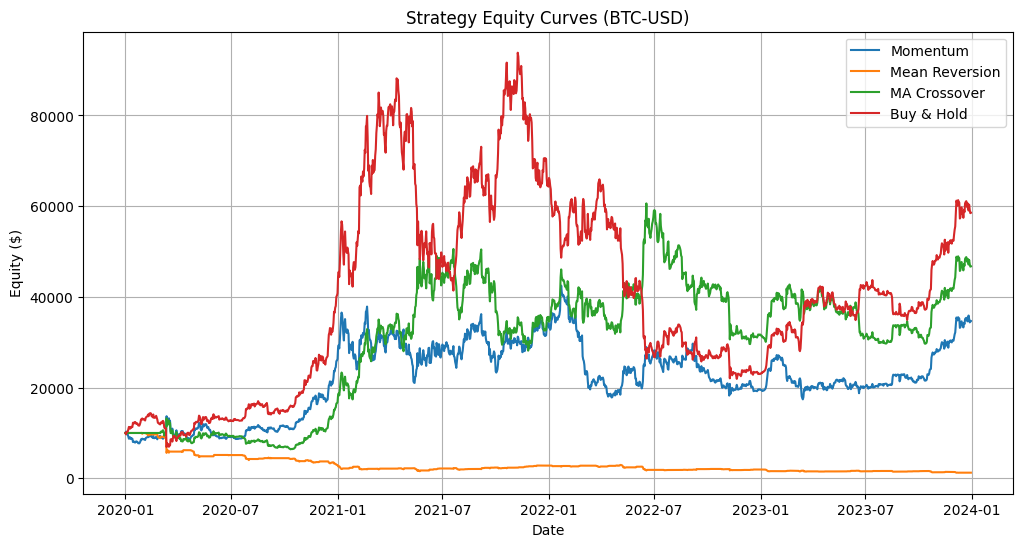

In [13]:
plot_equity_curves(equity_curves, title="Strategy Equity Curves (BTC-USD)")

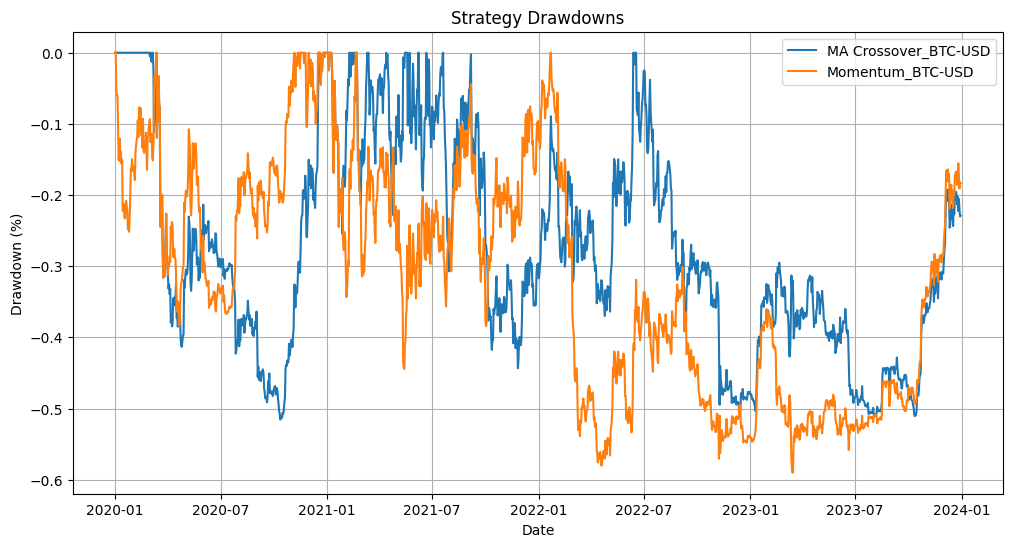

In [14]:
plot_drawdowns(combined_returns[['MA Crossover_BTC-USD', 'Momentum_BTC-USD']], title="Strategy Drawdowns")

## 6. Results Discussion & Analysis

### Strategy Performance
*   **Moving Average Crossover (Winner):** This was the most robust strategy for BTC, achieving a **30% CAGR** and the highest **Sortino Ratio (1.06)**. It successfully captured the major trends while staying out during some of the bear market chops.
*   **Momentum:** Also profitable for BTC (24% CAGR) but with slightly higher volatility than the MA Crossover. It failed to generate profit on ETH during this period.
*   **Mean Reversion (Loser):** This strategy performed poorly across the board. The negative CAGR indicates that betting against the trend (expecting prices to revert to the mean) is dangerous in the strongly trending crypto markets of 2020-2023.

### Asset Comparison
*   **BTC vs. ETH:** The factor strategies generally worked better on Bitcoin. Ethereum's price action might require different parameter tuning (e.g., faster signals) or different factors altogether.

### Risk Profile
*   **Drawdowns:** Even the winning strategies suffered significant drawdowns (~50%). This is characteristic of long-only crypto strategies. The **Calmar Ratio** helps us see that MA Crossover gave the best "return for risk" trade-off.